In [73]:
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pprint

from tabnanny import verbose
from pipe import where,select,traverse,dedup
from collections import defaultdict
from copy import deepcopy
from src.utils import Stack

In [153]:
class Utils(object):
	verbose: bool = True
	r"""A global boolean property to specify if the wrapper must print contents or
	not."""

	@staticmethod
	def print(*args, **kwargs):

		if 'flush' not in kwargs:
			kwargs['flush'] = True

		if kwargs.get('verbose', Utils.verbose):
			# del kwargs['verbose']
			print(*args, **kwargs)


#This class represents a undirected graph using adjacency processed_nodes representation
class Undirectedgraph:

	def __init__(self,m,tree_type='merge'):
		self.graph = defaultdict(list) # default dictionary to store graph
		self.m = m
		self.min = m.min()
		self.max = m.max()
		self.tree_type = tree_type
		self.m_flat = self.m.flatten()
		self.m_flat.sort()
		if self.tree_type == 'split':
			self.m_flat = np.flip(self.m_flat)
		Utils.print(self.m_flat)
	
	def __repr__(self) -> dict:
		return self.graph
	
	# degree of a node
	def degree(self,node) -> int:
		return len(self.graph[node])
	
	# function to add an edge to graph
	def addEdge(self,u,v):
		self.graph[u].append(v)
		self.graph[v].append(u)
		
	# method to delete a node and its edges
	def delete(self,n):
		list(self.graph[n] | select(lambda x:self.graph[x].remove(n)))
		del(self.graph[n])
	
	# get adjacent neighbours of a node in tree 
	def get_neighbours(self,node):
		return self.graph[node]
	
	# A utility function to find the root parent of an element i
	def find_parent(self, parent,i):
		if parent[i] == -1:
			return i
		if parent[i]!= -1:
			return self.find_parent(parent,parent[i])

	# A utility function to do union of two subsets
	def union(self,parent,x,y):
		parent[x] = y


	def get_index(self, item):
		[x, y] = np.where(self.m == item)
		x, y = x[0], y[0]
		return x, y
	
	def is_neighbour(self,children,node):
		[r, c] = self.m.shape
		[x, y] = self.get_index(node)

		for child in children:
			if child in self.m[max(0,x-1):min(x+2,r), max(y-1,0):min(y+2, c)]:
				return True
		
		return False
    
	def merge_sets(self,sets,node):
		con_com = {node:[],-1:[]}
		# Utils.print(f'before merging processed_nodes{sets}')
		for subset in sets:
			if node in subset:
				con_com[node].append(subset)
				con_com[node] = list(con_com[node] | traverse | dedup)
			else:
				con_com[-1].append(subset)

		sets = [con_com[node]]
		if len(con_com[-1])!= 0:
			for i in con_com[-1]: sets.append(i)
		con_com.clear()
		Utils.print(f'post merging processed_nodes{sets}')
		return sets

	def build_tree(self,node,processed_nodes):
		flag_no_neigbhour = True
		if len(processed_nodes)!=0:
			for idx,subset in enumerate(processed_nodes):
				Utils.print(f'\nsubset {subset} from processed nodes {processed_nodes}, node is {node}')
				Utils.print(f'is node {node} a neighbour of subset{subset}{self.is_neighbour(subset,node)}')
				if self.is_neighbour(subset,node):
					if self.tree_type == 'merge':
						self.addEdge(np.max(subset),node)
					else:
						self.addEdge(np.min(subset),node)
					Utils.print(f'appending node {node} to processed_nodes {processed_nodes}')
					processed_nodes[idx].append(node)
					flag_no_neigbhour = False

			if flag_no_neigbhour:
				processed_nodes.append([node])
			else:
				processed_nodes = self.merge_sets(processed_nodes,node)
		else:
			processed_nodes.append([node])
		return processed_nodes

	# Augment tree
	def augmentDFS(self,root : int):
			'''
		Args
			root:any node in graph 

		Purpose
			Recursive method of Graph augmentation of graph retaining only critical nodes(a.k.a saddle points)
			and root nodes reducing the size of graph considerably

		Output
			returns: None

		time complexity: T(n-1)+ O(n)
		Space complexity: O(n)
		'''

		saddle_point = []
		visited=set()

		_ = self.DFSUtil(root,saddle_point,visited)

	def DFSUtil(self,v : int,saddle_point,visited):

		visited.add(v)
		if self.degree(v)>2:
			saddle_point.append(v)
			
		
		Utils.print(f'\nnode :{v} | saddle points :{saddle_point}')
		Utils.print(f'neighbours of node {v} are {self.graph[v]}')

		buffer_nodes = self.graph[v].copy()
		for neighbour in buffer_nodes:
			if neighbour not in visited:
				saddle_point = self.DFSUtil(neighbour,saddle_point,visited)
		
		deg = self.degree(v) 
		if deg==1:
			Utils.print(f'degree of node {v} is {deg}')
			
			self.graph[v]=[saddle_point[-1]]
			if v not in self.graph[saddle_point[-1]]:
				self.graph[saddle_point[-1]].append(v)
			
			Utils.print(f'graph {self.graph}\nvisited {visited}')
		
		elif deg==2:
			Utils.print(f'degree of node {v} is {deg}')
		
			for node in saddle_point:
				if v in self.graph[node]:
					Utils.print(f'removing node {v} from saddle point{saddle_point[-1]}')
					self.graph[node].remove(v)
		
			Utils.print(f'removing node {v} from graph')
			del(self.graph[v])
			Utils.print(f'post removal {self.graph}\nvisited {visited}')
		
		elif deg>2 and len(saddle_point)>=2:
			Utils.print(f'degree of node {v} is {deg}, saddle points are {saddle_point}')
			
			result = all(node in visited for node in self.graph[saddle_point[-1]])
			if result and (saddle_point[-1] not in self.graph[saddle_point[-2]]):
				self.graph[saddle_point[-1]].append(saddle_point[-2])
				self.graph[saddle_point[-2]].append(saddle_point[-1])
				if set(self.graph[saddle_point[-2]]) & set(self.graph[saddle_point[-1]]):
					com_elem = set(self.graph[saddle_point[-2]]) & set(self.graph[saddle_point[-1]]) 
					com_elem = com_elem.pop()
					self.graph[saddle_point[-1]].remove(com_elem)
					self.graph[saddle_point[-2]].remove(com_elem)
			saddle_point.pop(-1)
		return saddle_point
		
	# iterative algorithm 
	def augment(self,root : int):

		saddle_point = Stack()
		visited=set()
		to_visit=Stack()

		saddle_point.push(root)    
		to_visit.push(root)

		def get_unvisited(n):
			return list(self.get_neighbours(n) | where(lambda x : x not in visited))
		iteration=1
		while len(to_visit)>0 and iteration<100:
			
			Utils.print(f'iteration {iteration}')
			Utils.print(f'graph is {self.graph}')
			Utils.print(f'to visit are {to_visit.stack}')
			
			n=to_visit.pop()
			Utils.print(f'popped node {n}')
			if self.degree(n)>2:
				saddle_point.push(n)
			visited.add(n)
			
			Utils.print(f'saddle points are {saddle_point.stack}')
			Utils.print(f'visited nodes are {visited}')
			Utils.print(f'degree of node {n} is {self.degree(n)}')
			
			# first node or last node
			if self.degree(n) == 1:
				if list(self.get_neighbours(n) | select(lambda x: x not in visited) | dedup)[0]:
					tmp_list = get_unvisited(n)
					for elem in tmp_list:
						to_visit.push(elem)	
				# last node 					
				else:
					Utils.print(f'last node {n}\'s neighbours are {self.get_neighbours(n)}')
					if list(self.get_neighbours(self.get_neighbours(n)[0]) | select(lambda x: x in visited))[0]:
						saddle_point.pop()
			
			# if node has 2 neighbours only	
			elif self.degree(n) == 2:
				# node to be removed and make connections between its neighbours
				self.addEdge(saddle_point.stack[-1],get_unvisited(n)[0])
				to_visit.push(list(self.get_neighbours(n) | where(lambda x:x not in visited )))
				self.delete(n)
			
			# if node is a saddle point
			else:
				to_visit.push(list(self.get_neighbours(n) | where(lambda x:x not in visited ))) ## get neighnbours not in visited list??????

			iteration+=1	
	
	# optimized iterative algorithm 
	def augment2(self,root: int):
		'''
		Args
			root:any node in graph 

		Purpose
			Iterative method of Graph augmentation of graph retaining only critical nodes(a.k.a saddle points)
			and root nodes reducing the size of graph considerably

		Output
			returns: None

		time complexity: O(n^2)
		Space complexity: O(n)
		'''
		to_visit=[]
		to_visit.append(root)
		counter=0
		
		while(counter<len(to_visit)):
			node=to_visit[counter]
			neighbours=self.get_neighbours(node)
			if self.degree(node)==2:
				self.addEdge(neighbours[0],neighbours[1])
				self.delete(node)
			to_visit=to_visit+list(neighbours | where(lambda x: x not in to_visit))
			counter+=1

		del(to_visit)
		del(counter)


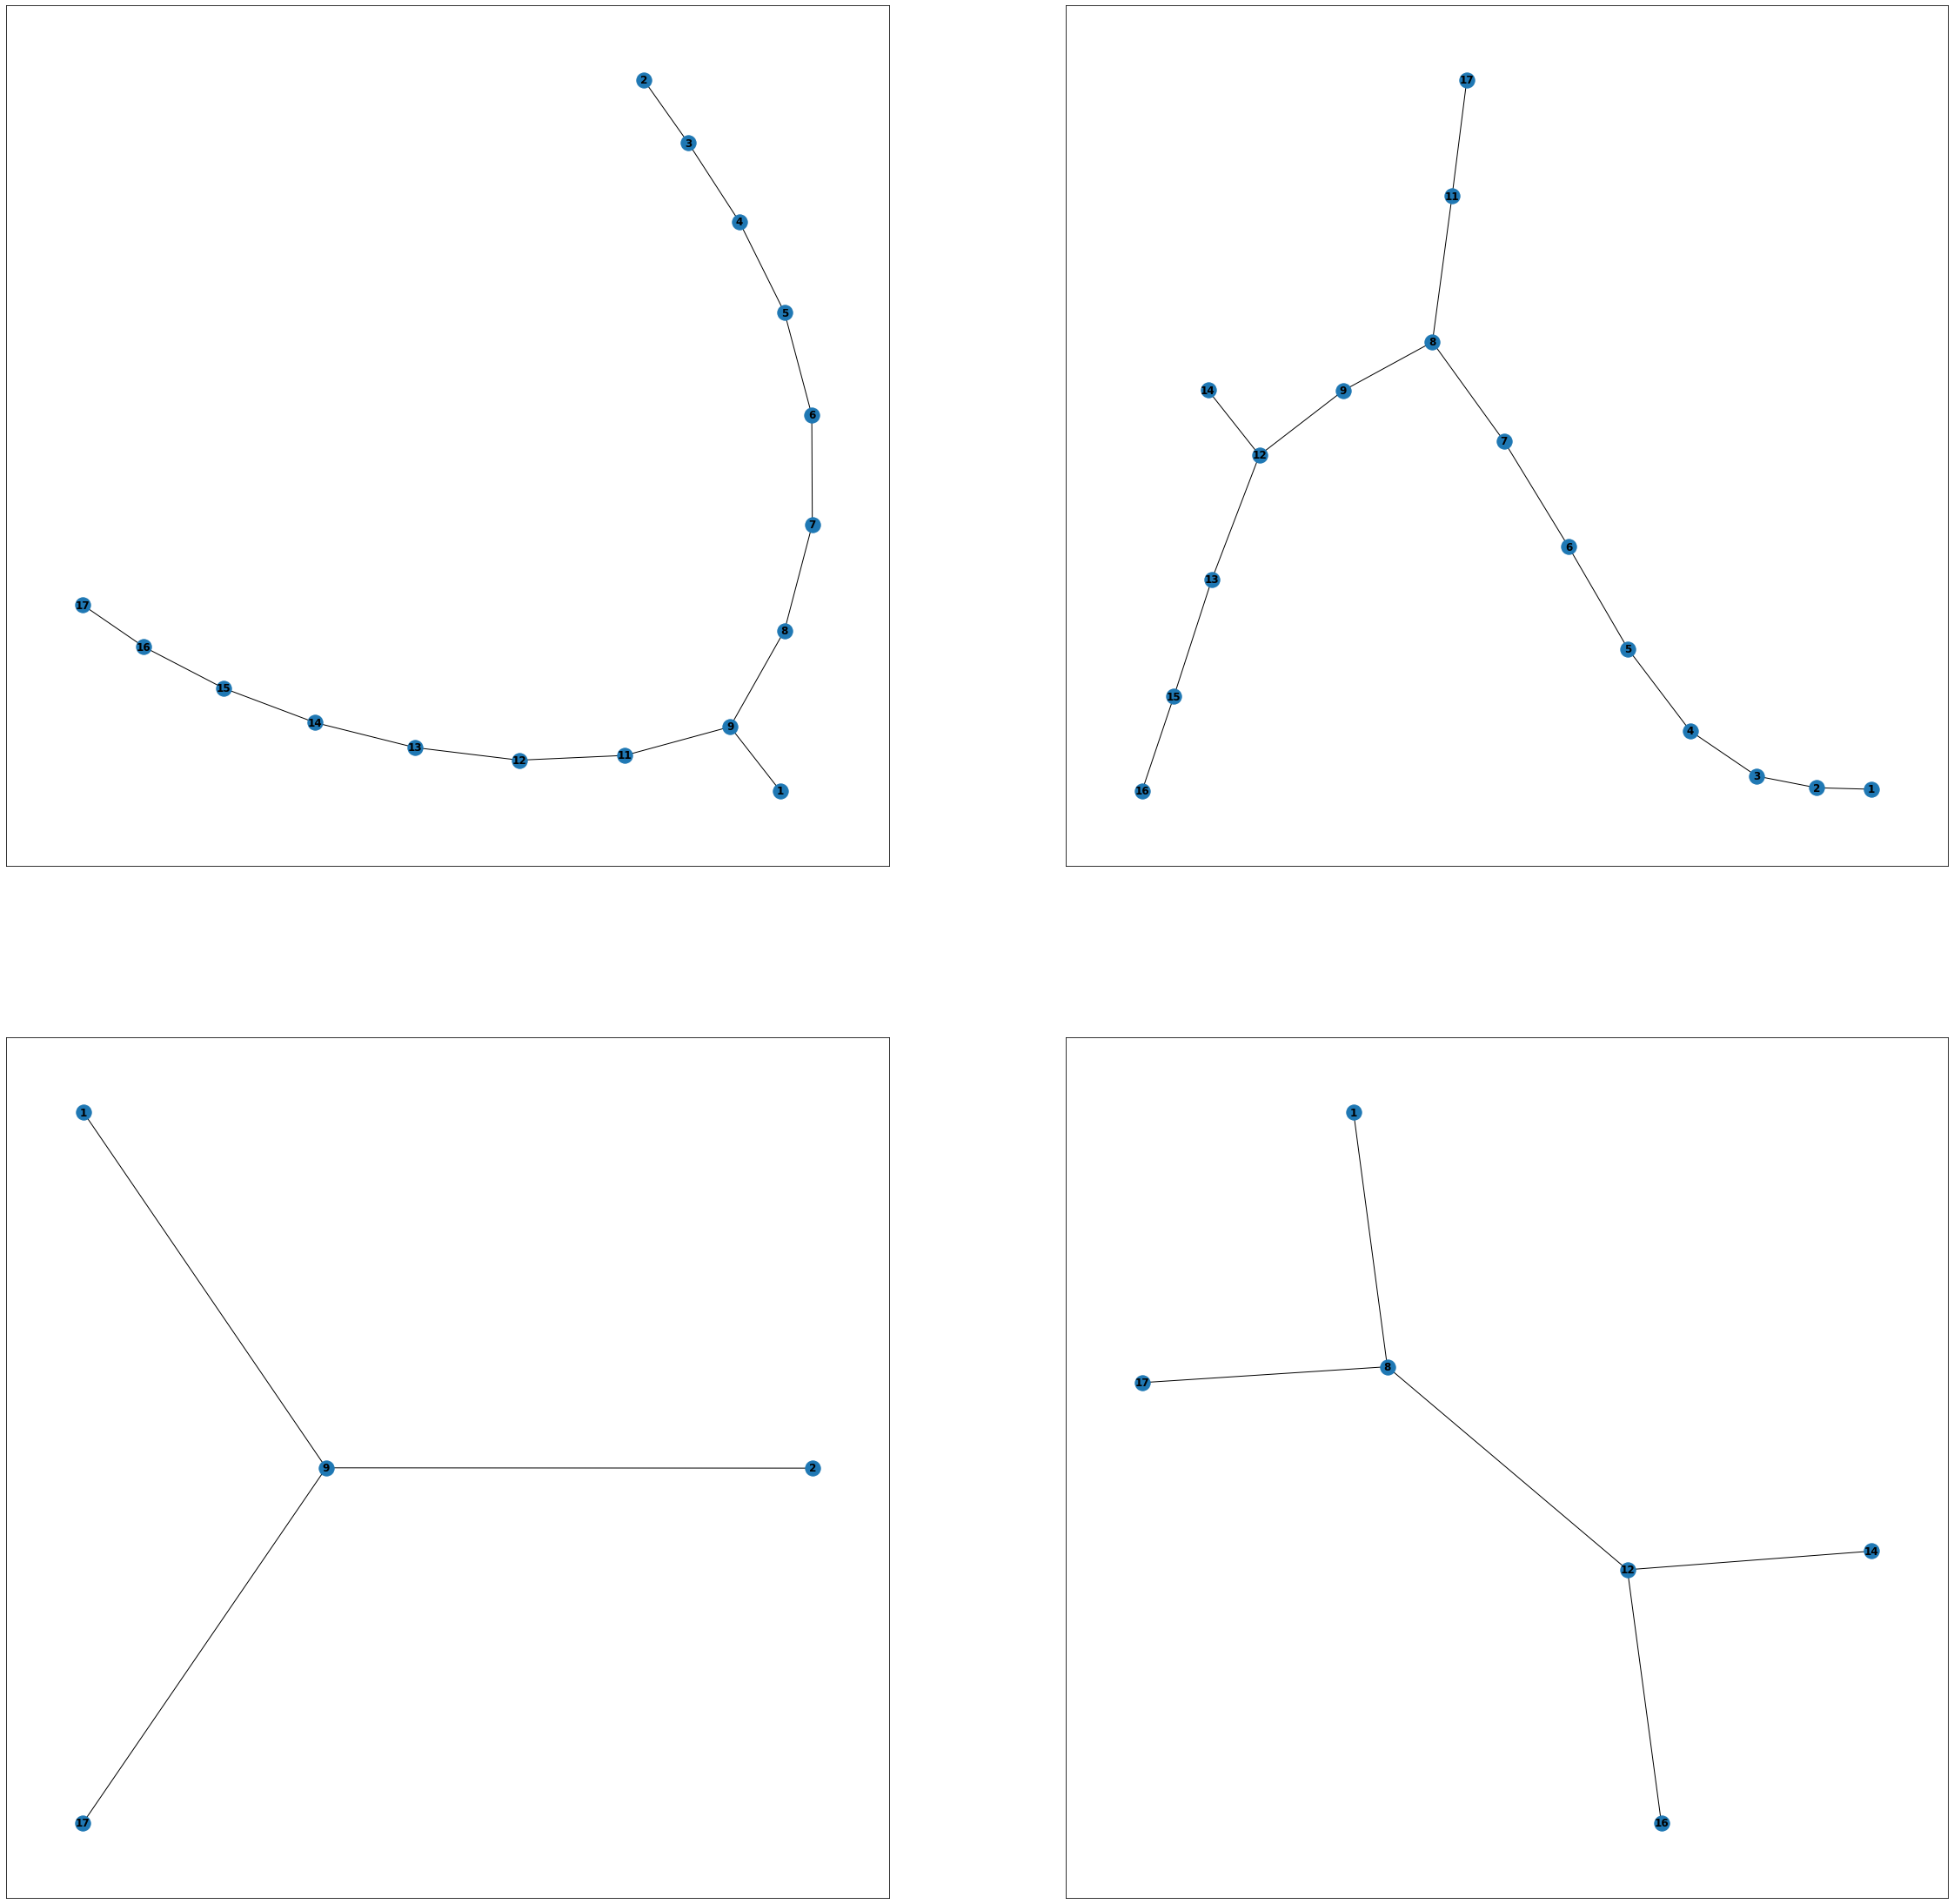

In [157]:
def get_reeb(m,tree_type):
    g = Undirectedgraph(m,tree_type=tree_type)
    G = nx.Graph()
    processed_nodes = []
                                                                                 # O(n)  space complexity
    for node in g.m_flat:
        processed_nodes = g.build_tree(node,processed_nodes)
    
    processed_nodes = processed_nodes.pop()
    initial_g = deepcopy(g.graph)
    
    Utils.print(f'augmenting tree\n')
    g.augment2(root=np.random.choice(processed_nodes,1)[0])
   
    return processed_nodes,initial_g,g.graph
    
    
if __name__ == "__main__":
    Utils.verbose = False
    unit_size = int(input('enter unit size as integer :'))
    # tree_type = str(input("enter type of tree 'merge/split' :"))
    scalar_field = np.random.choice(np.arange(1,np.square(unit_size)+3),size=(unit_size,unit_size),replace=False)
    Utils.print(f'input scalar field is\n\n {scalar_field}')
    
    _,merge_tree,aug_merge_tree = get_reeb(scalar_field,tree_type='merge')
    _,split_tree,aug_split_tree = get_reeb(scalar_field,tree_type='split')

    # pprint.pprint(f'initial tree for merge: {merge_tree}\n')
    # pprint.pprint(f'initial tree for split :{split_tree}\n')
    
    Gm = nx.Graph(merge_tree)
    Gm_a = nx.Graph(aug_merge_tree)
    Gs = nx.Graph(split_tree)
    Gs_a = nx.Graph(aug_split_tree)
    plt.figure(figsize=(40,40))
    
    plt.subplot(221)
    nx.draw_networkx(Gm, font_weight='bold')
    
    plt.subplot(222)
    nx.draw_networkx(Gs, font_weight='bold')
    
    plt.subplot(223)
    nx.draw_networkx(Gm_a, font_weight='bold')
    
    plt.subplot(224)
    nx.draw_networkx(Gs_a, font_weight='bold')
    
    plt.show()



## Testing

In [ ]:
global graph 
# graph = {14: [13], 13: [14, 12], 12: [13, 10], 17: [11], 11: [17, 9], 10: [12, 7], 9: [11, 15, 8], 15: [9], 8: [9, 7], 7: [8, 10, 6], 6: [7, 16, 5], 16: [6], 5: [6, 4], 4: [5, 2], 2: [4, 1], 1: [2]}
# graph = {18: [17], 17: [18, 14], 16: [15], 15: [16, 12], 14: [17, 13], 13: [14, 12], 12: [13, 15, 11], 11: [12, 9], 9: [11, 8], 8: [9, 7], 7: [8, 6], 6: [7, 5], 5: [6, 4], 4: [5, 3], 3: [4, 2], 2: [3]}
graph = {4: [5], 5: [4, 9], 3: [6], 6: [3, 7], 7: [6, 2, 8], 2: [7], 8: [7, 9], 9: [8, 5, 11], 11: [9, 12], 12: [11, 13], 13: [12, 14], 14: [13, 15], 15: [14, 16], 16: [15, 17], 17: [16, 18], 18: [17]}

In [ ]:
# testing for recursive function
def DFS(v : int):
        
    root = v
    saddle_point = []
    visited=set()

    _ = DFSUtil(root,saddle_point,visited)
    print(f'final graph is {graph}')

def DFSUtil(v : int,saddle_point,visited):
    
    def degree(node):
        if node in graph.keys():
            return len(graph[node])

    visited.add(v)
    if degree(v)>2:
        saddle_point.append(v)
        
    
    print(f'\nnode :{v} | saddle points :{saddle_point}')
    print(f'neighbours of node {v} are {graph[v]}')
    buffer_nodes = graph[v].copy()
    for neighbour in buffer_nodes:
        if neighbour not in visited:
            print(f'calling function DFSUtil({neighbour},{saddle_point})')
            saddle_point = DFSUtil(neighbour,saddle_point,visited)
    
    deg = degree(v) 
    if deg==1:
        # print(f'degree of node {v} is {degree(v)}')
        graph[v]=[saddle_point[-1]]
        if v not in graph[saddle_point[-1]]:
            graph[saddle_point[-1]].append(v)
        # print(f'graph {graph}\nvisited {visited}')
    elif deg==2:
        # print(f'degree of node {v} is {degree(v)}')
        for node in saddle_point:
            if v in graph[node]:
                # print(f'removing node {v} from saddle point{saddle_point[-1]}')
                graph[node].remove(v)
        # print(f'removing node {v} from graph')
        del(graph[v])
        # print(f'post removal {graph}\nvisited {visited}')
    elif deg>2 and len(saddle_point)>=2:
        # print(f'degree of node {v} is {degree(v)}, saddle points are {saddle_point}')
        result = all(node in visited for node in graph[saddle_point[-1]])
        if result and (saddle_point[-1] not in graph[saddle_point[-2]]):
            graph[saddle_point[-1]].append(saddle_point[-2])
            graph[saddle_point[-2]].append(saddle_point[-1])
            if set(graph[saddle_point[-2]]) & set(graph[saddle_point[-1]]):
                com_elem = set(graph[saddle_point[-2]]) & set(graph[saddle_point[-1]]) 
                com_elem = com_elem.pop()
                graph[saddle_point[-1]].remove(com_elem)
                graph[saddle_point[-2]].remove(com_elem)
        saddle_point.pop(-1)
    return saddle_point


G1 = nx.Graph(graph)
nx.draw_networkx(G1,font_weight='bold')
plt.show()



In [ ]:
graph={2: [3], 3: [2, 4], 4: [3, 5], 5: [4, 1, 7], 1: [5], 7: [5, 6, 8], 6: [7], 8: [7, 11], 11: [8]}
result=({1: [2], 11: [10]})

In [ ]:
G1 = nx.Graph(graph)
nx.draw_networkx(G1,font_weight='bold')
plt.show()

In [ ]:
G2 = nx.Graph(result)
nx.draw_networkx(G2,font_weight='bold')
plt.show()